This version dropped body weight, and used both apsiii and oasis for PSM and regression analyses

Correction: AUC sld be roc_auc_score(y, **probas_**) NOT roc_auc_score(y, pred)

added apsiii and oasis in the covariate_table

https://medium.com/@bmiroglio/introducing-the-pymatch-package-6a8c020e2009

In [85]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
from pymatch.Matcher import Matcher
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve

In [86]:
df = pd.read_csv('./data/df_clean_0424_CVICU.csv')
print(df.shape)
df.head()

(577, 29)


,subject_id,los,hospital_expire_flag,expose,age,gender,heart_rate_first24h_mean,mbp_first24h_mean,resp_rate_first24h_mean,spo2_first24h_mean,...,heart_rhythm_first24h_firstRecorded,heart_rhythm_first24h_numTypeRecorded,charlson_comorbidity_index,lowest_gcs_motor_eyes_first24h,last_gcs_motor_eyes,last_gcs_motor,first_gcs_motor_eyes,apsiii,oasis,heart_rhythm_cat
0,10001884,9.0,1,0,77.01830,F,71.39286,86.03846,17.77586,98.25926,...,V Paced,2.0,6,2.0,10,6,2.0,56,34,rare rhythm
1,10024982,21.0,1,0,85.71412,M,63.11111,84.28000,19.24074,99.88889,...,AF (Atrial Fibrillation),2.0,7,2.0,2,1,2.0,100,45,AF (Atrial Fibrillation)
2,10109956,14.0,0,1,62.34224,F,99.12245,86.67000,21.22917,97.57447,...,SR (Sinus Rhythm),2.0,10,2.0,10,6,2.0,86,52,SR (Sinus Rhythm)
3,10131457,11.0,0,0,41.21647,M,54.08333,90.55932,16.84167,99.33333,...,SB (Sinus Bradycardia),2.0,2,2.0,10,6,9.0,31,33,rare rhythm
4,10144145,15.0,1,0,55.00510,M,68.73077,63.44000,17.34615,98.92308,...,SR (Sinus Rhythm),1.0,5,2.0,9,5,2.0,109,33,SR (Sinus Rhythm)


In [87]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 577 entries, 0 to 576
Data columns (total 29 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   subject_id                             577 non-null    int64  
 1   los                                    577 non-null    float64
 2   hospital_expire_flag                   577 non-null    int64  
 3   expose                                 577 non-null    int64  
 4   age                                    577 non-null    float64
 5   gender                                 577 non-null    object 
 6   heart_rate_first24h_mean               577 non-null    float64
 7   mbp_first24h_mean                      577 non-null    float64
 8   resp_rate_first24h_mean                577 non-null    float64
 9   spo2_first24h_mean                     577 non-null    float64
 10  heart_rate_first24h_max                577 non-null    float64
 11  mbp_fi

In [88]:
X = df.drop(['subject_id', 'los','hospital_expire_flag','expose',
    'mbp_first24h_mean', 'resp_rate_first24h_mean', 'spo2_first24h_mean',
    'mbp_first24h_min',  'resp_rate_first24h_min',  'spo2_first24h_min', 'heart_rate_first24h_min',
    'mbp_first24h_max',  'resp_rate_first24h_max',  'spo2_first24h_max', 'heart_rate_first24h_max',     
    'first_gcs_motor_eyes', 'last_gcs_motor_eyes', 'last_gcs_motor','heart_rhythm_first24h_firstRecorded', 'icu_entrydate_weekend',
    'heart_rhythm_first24h_numTypeRecorded'], axis=1)

X = pd.get_dummies(X, columns=['gender','heart_rhythm_cat'], drop_first=True)
y = df['expose']

In [89]:
X.columns

Index(['age', 'heart_rate_first24h_mean', 'charlson_comorbidity_index',
       'lowest_gcs_motor_eyes_first24h', 'apsiii', 'oasis', 'gender_M',
       'heart_rhythm_cat_SR (Sinus Rhythm)',
       'heart_rhythm_cat_ST (Sinus Tachycardia) ',
       'heart_rhythm_cat_rare rhythm'],
      dtype='object')

In [90]:
param_grid = {'max_depth': [1, 2, 5, 10, 15],
         'n_estimators': [10, 20, 30, 50, 100],
         'learning_rate': [0.01, 0.02, 0.05, 0.1, 0.2, 0.5]}

lgbm = GridSearchCV(lgb.LGBMClassifier(
    boosting_type='gbdt', n_jobs=-1, random_state=1),
    param_grid=param_grid, cv=5, n_jobs=-1,
    scoring='roc_auc', refit = True)
lgbm.fit(X, y)
lgbm.best_params_

{'learning_rate': 0.5, 'max_depth': 1, 'n_estimators': 20}

In [91]:
lgbm_pred = lgbm.predict(X)
lgbm_probas_ = lgbm.predict_proba(X)
print('Accuracy:',accuracy_score(y, lgbm_pred))
print('AUC:', roc_auc_score(y, lgbm_probas_[:,1]))

Accuracy: 0.7694974003466204
AUC: 0.8337410089365721


In [92]:
df['score'] = lgbm_probas_[:, 1]

In [93]:
excl_covariates = ['subject_id', 'los','hospital_expire_flag','score',
    'mbp_first24h_mean', 'resp_rate_first24h_mean', 'spo2_first24h_mean',
    'mbp_first24h_min',  'resp_rate_first24h_min',  'spo2_first24h_min', 'heart_rate_first24h_min',
    'mbp_first24h_max',  'resp_rate_first24h_max',  'spo2_first24h_max', 'heart_rate_first24h_max',
    'first_gcs_motor_eyes', 'last_gcs_motor_eyes','last_gcs_motor','heart_rhythm_first24h_firstRecorded', 'icu_entrydate_weekend',
    'heart_rhythm_first24h_numTypeRecorded']

test = df[df.expose==1]
control = df[df.expose==0]

m = Matcher(test, control, yvar="expose", exclude=excl_covariates)

Formula:
expose ~ age+gender+heart_rate_first24h_mean+charlson_comorbidity_index+lowest_gcs_motor_eyes_first24h+apsiii+oasis+heart_rhythm_cat
n majority: 314
n minority: 263


In [94]:
np.random.seed(1234)
m.fit_scores(balance=True, nmodels=100)
m.predict_scores()
# ignore the accuracy score

Fitting Models on Balanced Samples: 100\100
Average Accuracy: 73.61%


In [95]:
# lg_pred = np.where(m.data['scores']>=0.5,1,0)
print('AUC:', roc_auc_score(y, m.data['scores']))

AUC: 0.5415223656486886


In [96]:
m.data['scores'] = m.data['score']
m.data = m.data.drop(['score'],axis=1)
print('Accuracy:',accuracy_score(y, lgbm_pred))

Accuracy: 0.7694974003466204


In [97]:
# rec threshold
thresh = np.std(m.data['scores'])*0.2
thresh

0.043470276180507986

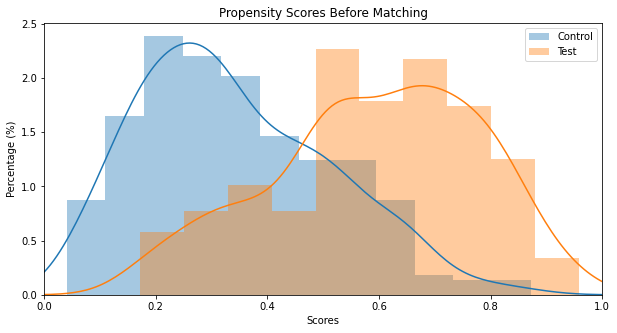

In [98]:
m.plot_scores()

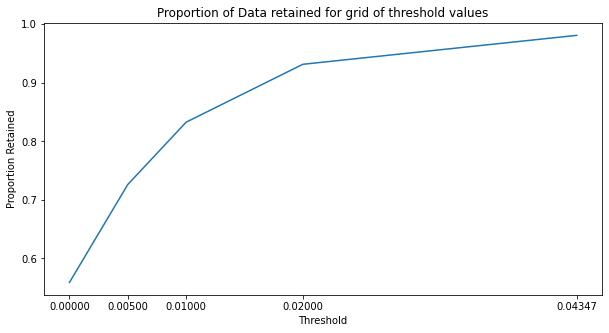

In [99]:
m.tune_threshold(method='random', rng=[0., 0.005, 0.01, 0.02, thresh])

In [100]:
m.match(method="random", nmatches=1, threshold=thresh)

In [101]:
m.record_frequency()

,freq,n_records
0,1,321
1,2,23
2,3,12
3,4,3
4,5,2
5,6,1
6,7,2
7,9,1
8,10,2
9,12,1


In [102]:
m.assign_weight_vector()

In [103]:
m.matched_data.sort_values("match_id").head(6)
m.matched_data.shape

(516, 33)

,var,before,after
0,gender,0.747718,0.309609
1,heart_rhythm_cat,0.067651,0.006238


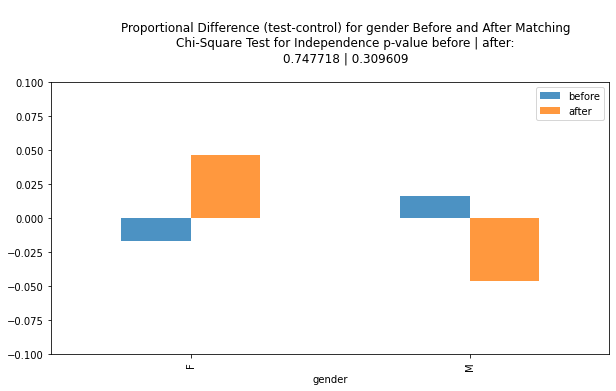

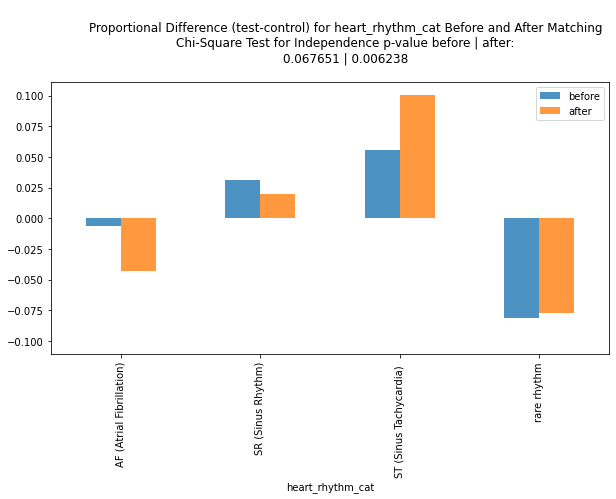

In [104]:
# compare before/after categorical features 
m.compare_categorical(return_table=True)

,var,ks_before,ks_after,grouped_chisqr_before,grouped_chisqr_after,std_median_diff_before,std_median_diff_after,std_mean_diff_before,std_mean_diff_after
0,age,0.001,0.013,0.000,0.001,-0.328057,-0.304026,-0.343401,-0.263511
1,heart_rate_first24h_mean,0.000,0.091,0.000,0.152,-0.534931,0.152604,-0.571661,0.094981
2,charlson_comorbidity_index,0.000,0.000,0.021,0.000,-0.343637,-0.319337,-0.433772,-0.414643
3,lowest_gcs_motor_eyes_first24h,0.000,0.710,1.000,1.000,0.000000,0.000000,-0.449929,-0.031862
4,apsiii,0.006,0.423,0.093,0.804,0.326205,-0.114968,0.223536,-0.092687
5,oasis,0.089,0.004,0.061,0.003,0.223490,-0.118394,0.079260,-0.174379


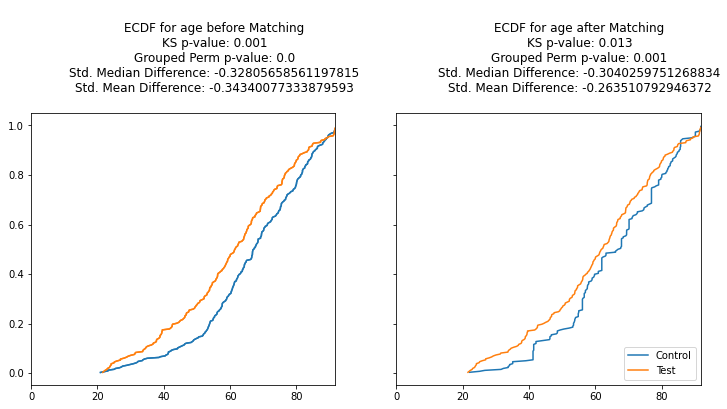

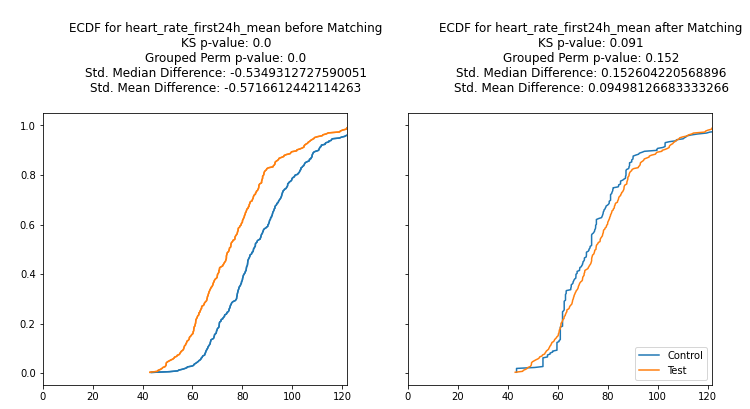

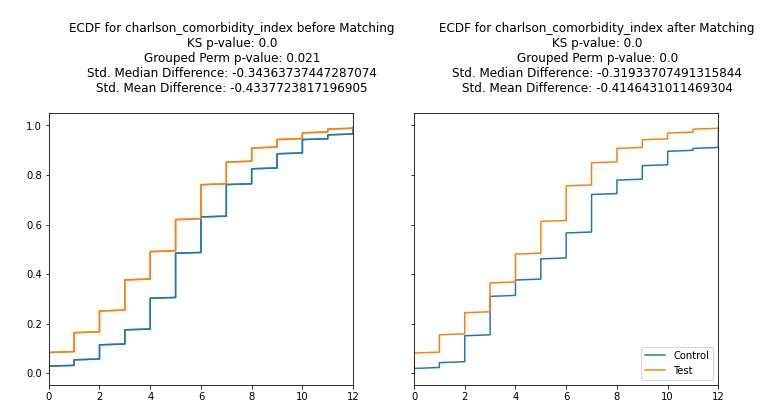

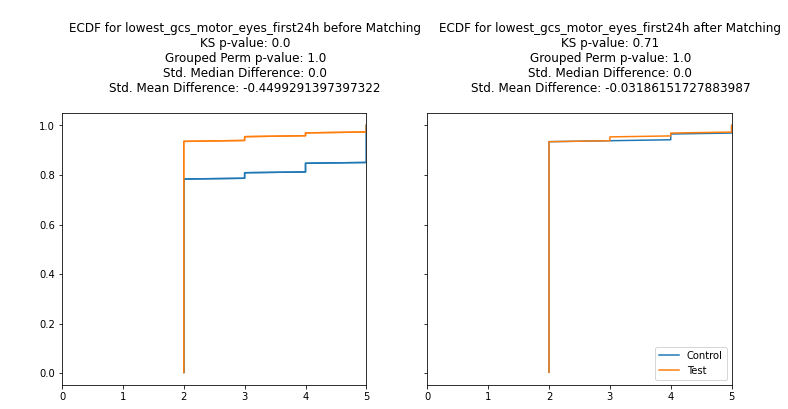

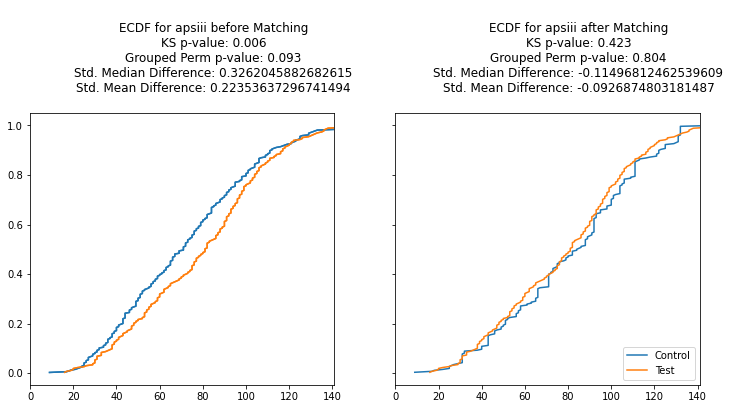

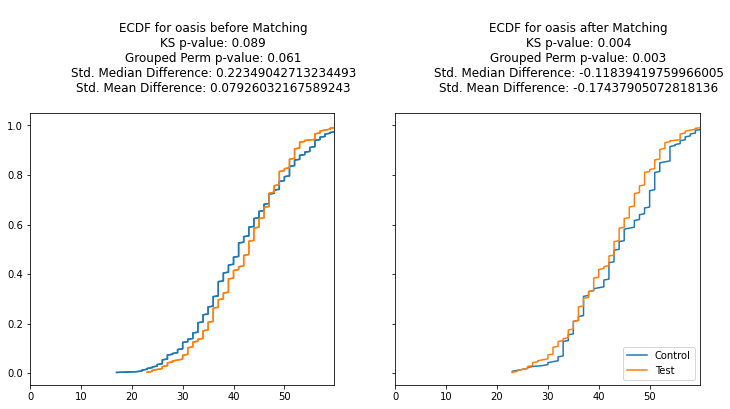

In [105]:
# compare before/after continuous features 
m.compare_continuous(return_table=True)

Increasing the number of untreated subjects matched to each treated subject tended to increase the bias in the estimated treatment effect; conversely, increasing the number of untreated subjects matched to each treated subject decreased the sampling variability of the estimated treatment effect. https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2962254/

In [106]:
matched_1to1 = m.matched_data.sort_values("match_id")
matched_1to1.shape
matched_1to1['scores'].head()

0      0.283418
459    0.264827
1      0.671516
412    0.662848
290    0.746601
Name: scores, dtype: float64

In [107]:
# p = matched_1to1['scores']*matched_1to1['expose'] + (1-matched_1to1['scores'])*(1-matched_1to1['expose'])
# matched_1to1['ipw'] = 1 + np.exp(-np.log(p/(1-p)))
matched_1to1['ipw'] = 1+matched_1to1['scores']

matched_1to1['ipw_freq'] = matched_1to1['ipw']*matched_1to1['weight']
matched_1to1.shape

(516, 35)

In [108]:
#matched_1to1.rename(columns={'weight':'bodyweight'}, inplace=True)

In [109]:
matched_1to1.head()

,record_id,weight,subject_id,los,hospital_expire_flag,expose,age,gender,heart_rate_first24h_mean,mbp_first24h_mean,...,last_gcs_motor_eyes,last_gcs_motor,first_gcs_motor_eyes,apsiii,oasis,heart_rhythm_cat,scores,match_id,ipw,ipw_freq
0,0,1.000000,10109956,14.0,0,1,62.34224,F,99.12245,86.67000,...,10,6,2.0,86,52,SR (Sinus Rhythm),0.283418,0,1.283418,1.283418
459,473,1.000000,16332400,3.0,1,0,66.82519,F,66.52500,69.89744,...,4,1,5.0,84,52,SR (Sinus Rhythm),0.264827,0,1.264827,1.264827
1,1,1.000000,10150911,7.0,0,1,58.80580,F,65.64286,88.43750,...,10,6,2.0,125,58,rare rhythm,0.671516,1,1.671516,1.671516
412,407,1.000000,14770561,3.0,1,0,53.69478,M,73.81250,81.34848,...,2,1,2.0,118,49,SR (Sinus Rhythm),0.662848,1,1.662848,1.662848
290,306,0.111111,11522912,15.0,1,0,67.88628,M,59.68966,95.42857,...,5,4,2.0,43,37,SR (Sinus Rhythm),0.746601,2,1.746601,0.194067


In [110]:
from statsmodels.stats import weightstats as st
from statsmodels.stats import meta_analysis as mt

control = df[df['expose']==0]
treatment = df[df['expose']==1]

variables = [
    'age','heart_rate_first24h_mean','apsiii','oasis',
    'charlson_comorbidity_index', 'lowest_gcs_motor_eyes_first24h']

lst = []

for i in variables:
    row_fill = []
    row_fill.append(i)
    row_fill.append(np.mean(treatment[i]))
    row_fill.append(np.std(treatment[i]))
    row_fill.append(np.mean(control[i]))
    row_fill.append(np.std(control[i]))
    row_fill.append(abs(mt.effectsize_smd(row_fill[1],row_fill[2], treatment.shape[0],row_fill[3],row_fill[4],control.shape[0])[0]))
    t_value, p_value, degfree = st.ttest_ind(control[i],treatment[i],alternative="two-sided",usevar="pooled")
    row_fill.append(t_value)
    row_fill.append(p_value)
    lst.append(row_fill)

covariate_table = pd.DataFrame(lst, columns=['Variable Name', 'Exposure Mean', 'Exposure std', 'Non-Exposure Mean', 'Non-Exposure std', 'SMD','t-value', 'p-value'])

#covariate_table['p-value'] = covariate_table['p-value'].round(decimals=3)
covariate_table

,Variable Name,Exposure Mean,Exposure std,Non-Exposure Mean,Non-Exposure std,SMD,t-value,p-value
0,age,60.320729,18.029427,66.250776,16.114638,0.348087,4.162445,3.630796e-05
1,heart_rate_first24h_mean,76.572195,17.391768,86.917440,17.310962,0.595564,7.121905,3.193743e-12
2,apsiii,78.543726,30.033394,71.691083,30.821917,0.224640,-2.686317,7.433285e-03
3,oasis,42.425856,8.138138,41.716561,9.563361,0.079217,-0.947317,3.438753e-01
4,charlson_comorbidity_index,4.600760,2.862555,5.863057,2.823419,0.443685,5.305686,1.604496e-07
5,lowest_gcs_motor_eyes_first24h,2.140684,0.577772,2.560510,1.113539,0.461028,5.513558,5.317755e-08


In [ ]:
import scipy
print(scipy.stats.mannwhitneyu(treatment['heart_rhythm_cat'], control['heart_rhythm_cat']))
print(scipy.stats.mannwhitneyu(treatment['gender'], control['gender']))
print(scipy.stats.mannwhitneyu(treatment['icu_entrydate_weekend'], control['icu_entrydate_weekend']))

In [ ]:
control.shape

In [ ]:
from statsmodels.stats import weightstats as st

control = matched_1to1[matched_1to1['expose']==0]
treatment = matched_1to1[matched_1to1['expose']==1]

variables = [
    'age','heart_rate_first24h_mean',
    'charlson_comorbidity_index', 'lowest_gcs_motor_eyes_first24h']

lst = []

for i in variables:
    row_fill = []
    row_fill.append(i)
    row_fill.append(np.mean(treatment[i]))
    row_fill.append(np.std(treatment[i]))
    row_fill.append(np.mean(control[i]))
    row_fill.append(np.std(control[i]))
    row_fill.append(abs(row_fill[1]-row_fill[3]))
    row_fill.append(abs(mt.effectsize_smd(row_fill[1],row_fill[2], treatment.shape[0],row_fill[3],row_fill[4],control.shape[0])[0]))
    t_value, p_value, degfree = st.ttest_ind(control[i],treatment[i],alternative="two-sided",usevar="pooled", weights=(control['weight'], treatment['weight']))
    row_fill.append(t_value)
    row_fill.append(p_value)
    lst.append(row_fill)

covariate_table = pd.DataFrame(lst, columns=['Variable Name', 'Exposure Mean', 'Exposure std', 'Non-Exposure Mean', 'Non-Exposure std', 'Mean Difference', 'SMD','t-value', 'p-value'])

covariate_table['p-value'] = covariate_table['p-value'].round(decimals=3)
covariate_table

In [ ]:
control.shape

In [ ]:
import scipy
print(scipy.stats.mannwhitneyu(treatment['heart_rhythm_cat'], control['heart_rhythm_cat']))
print(scipy.stats.mannwhitneyu(treatment['gender'], control['gender']))
print(scipy.stats.mannwhitneyu(treatment['icu_entrydate_weekend'], control['icu_entrydate_weekend']))

In [ ]:
#matched_1to1.to_csv('matched_1to1_lgbm_0415.csv', index=False)

# Statistical Analysis

In [ ]:
# # with ipw remove balanced covar (bodyweight, resp, spo2, lowest gcs)
# f = 'hospital_expire_flag ~ expose + age + C(gender) + heart_rate_first24h_mean + mbp_first24h_mean + C(heart_rhythm_cat) + charlson_comorbidity_index + C(icu_entrydate_weekend)'
# res = smf.glm(f, data=matched_1to1, family=sm.families.Binomial(),
#                freq_weights=matched_1to1['ipw_freq']).fit()
# res.summary()

In [ ]:
# odds_ratios = pd.DataFrame(
#     {
#         "OR": res.params,
#         "Lower CI": res.conf_int()[0],
#         "Upper CI": res.conf_int()[1],
#     }
# )
# odds_ratios = np.exp(odds_ratios)
# odds_ratios

In [111]:
# # with ipw weighting
# max
# f = 'hospital_expire_flag ~ expose + age + C(gender) + bodyweight + heart_rate_first24h_max + mbp_first24h_max + resp_rate_first24h_max + spo2_first24h_min + C(icu_entrydate_weekend) + C(heart_rhythm_cat) + charlson_comorbidity_index + first_gcs_motor_eyes'
# res = smf.glm(f, data=matched_1to1, family=sm.families.Binomial(),
#                freq_weights=matched_1to1['ipw']).fit()
# res.summary()

# # non-vitals
# f = 'hospital_expire_flag ~ expose + age + C(gender) + bodyweight + C(icu_entrydate_weekend) + C(heart_rhythm_cat) + charlson_comorbidity_index + first_gcs_motor_eyes'
# res = smf.glm(f, data=matched_1to1, family=sm.families.Binomial(),
#                freq_weights=matched_1to1['ipw']).fit()
# res.summary()

# # min
# f = 'hospital_expire_flag ~ expose + age + C(gender) + bodyweight + heart_rate_first24h_min + mbp_first24h_min + resp_rate_first24h_min + spo2_first24h_min + C(heart_rhythm_cat) + charlson_comorbidity_index + lowest_gcs_verbal_eyes_first24h + heart_rhythm_first24h_numTypeRecorded'
# res = smf.glm(f, data=matched_1to1, family=sm.families.Binomial(),
#                freq_weights=matched_1to1['ipw']).fit()
# res.summary()

# # #mean
f = 'hospital_expire_flag ~ expose + age + C(gender) + heart_rate_first24h_mean + mbp_first24h_mean + resp_rate_first24h_mean + spo2_first24h_mean + C(heart_rhythm_cat) + charlson_comorbidity_index + lowest_gcs_motor_eyes_first24h + C(icu_entrydate_weekend) + apsiii + oasis'
res = smf.glm(f, data=matched_1to1, family=sm.families.Binomial(),
               freq_weights=matched_1to1['ipw_freq']).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                  Generalized Linear Model Regression Results                   
================================================================================
Dep. Variable:     hospital_expire_flag   No. Observations:                  516
Model:                              GLM   Df Residuals:                   558.04
Model Family:                  Binomial   Df Model:                           15
Link Function:                    Logit   Scale:                          1.0000
Method:                            IRLS   Log-Likelihood:                -350.98
Date:                  Mon, 25 Apr 2022   Deviance:                       701.95
Time:                          21:46:17   Pearson chi2:                     576.
No. Iterations:                       4   Pseudo R-squ. (CS):             0.1597
Covariance Type:              nonrobust                                         
==================================================================================================================
                                                     coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
Intercept                                         -8.3766      6.568     -1.275      0.202     -21.249       4.496
C(gender)[T.M]                                    -0.4347      0.193     -2.248      0.025      -0.814      -0.056
C(heart_rhythm_cat)[T.SR (Sinus Rhythm)]          -0.5780      0.377     -1.532      0.125      -1.317       0.161
C(heart_rhythm_cat)[T.ST (Sinus Tachycardia) ]    -0.8677      0.419     -2.073      0.038      -1.688      -0.047
C(heart_rhythm_cat)[T.rare rhythm]                -1.3874      0.423     -3.280      0.001      -2.217      -0.558
C(icu_entrydate_weekend)[T.True]                   0.1721      0.205      0.838      0.402      -0.230       0.575
expose                                             0.4046      0.227      1.780      0.075      -0.041       0.850
age                                                0.0266      0.008      3.262      0.001       0.011       0.043
heart_rate_first24h_mean                           0.0189      0.007      2.525      0.012       0.004       0.034
mbp_first24h_mean                                  0.0036      0.008      0.429      0.668      -0.013       0.020
resp_rate_first24h_mean                            0.0423      0.027      1.585      0.113      -0.010       0.095
spo2_first24h_mean                                 0.0470      0.063      0.747      0.455      -0.076       0.170
charlson_comorbidity_index                        -0.0074      0.043     -0.174      0.862      -0.091       0.076
lowest_gcs_motor_eyes_first24h                    -0.0613      0.152     -0.404      0.686      -0.359       0.236
apsiii                                             0.0197      0.005      4.370      0.000       0.011       0.029
oasis                                             -0.0245      0.016     -1.497      0.134      -0.057       0.008
==================================================================================================================
"""

In [112]:
odds_ratios = pd.DataFrame(
    {
        "OR": res.params,
        "Lower CI": res.conf_int()[0],
        "Upper CI": res.conf_int()[1],
    }
)
odds_ratios = np.exp(odds_ratios)
odds_ratios

,OR,Lower CI,Upper CI
Intercept,0.000230,5.909513e-10,89.666860
C(gender)[T.M],0.647448,4.432244e-01,0.945771
C(heart_rhythm_cat)[T.SR (Sinus Rhythm)],0.561021,2.678764e-01,1.174963
C(heart_rhythm_cat)[T.ST (Sinus Tachycardia) ],0.419925,1.849022e-01,0.953677
C(heart_rhythm_cat)[T.rare rhythm],0.249714,1.089836e-01,0.572171
C(icu_entrydate_weekend)[T.True],1.187805,7.942203e-01,1.776435
expose,1.498643,9.599549e-01,2.339622
age,1.026949,1.010672e+00,1.043488
heart_rate_first24h_mean,1.019081,1.004236e+00,1.034146
mbp_first24h_mean,1.003622,9.871855e-01,1.020333


In [53]:
# # without ipw weighting


# f = 'hospital_expire_flag ~ expose + age + C(gender) + heart_rate_first24h_max + mbp_first24h_max + resp_rate_first24h_max + spo2_first24h_min + C(icu_entrydate_weekend) + C(heart_rhythm_cat) + charlson_comorbidity_index + first_gcs_motor_eyes'
# res = smf.glm(f, data=matched_1to1, family=sm.families.Binomial()).fit()
# res.summary()

# f = 'hospital_expire_flag ~ expose + age + C(gender) + C(icu_entrydate_weekend) + C(heart_rhythm_cat) + charlson_comorbidity_index + first_gcs_motor_eyes'
# res = smf.glm(f, data=matched_1to1, family=sm.families.Binomial()).fit()
# res.summary()

# f = 'hospital_expire_flag ~ expose + age + C(gender) + heart_rate_first24h_min + mbp_first24h_min + resp_rate_first24h_min + spo2_first24h_min + C(heart_rhythm_cat) + charlson_comorbidity_index + lowest_gcs_verbal_eyes_first24h + heart_rhythm_first24h_numTypeRecorded'
# res = smf.glm(f, data=matched_1to1, family=sm.families.Binomial()).fit()
# res.summary()

f = 'hospital_expire_flag ~ expose + age + C(gender) + heart_rate_first24h_mean + mbp_first24h_mean + resp_rate_first24h_mean + spo2_first24h_mean + C(heart_rhythm_cat) + charlson_comorbidity_index + lowest_gcs_motor_eyes_first24h + C(icu_entrydate_weekend) + apsiii + oasis'
res = smf.glm(f, data=matched_1to1, family=sm.families.Binomial(),freq_weights=matched_1to1['weight']).fit()
res.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                  Generalized Linear Model Regression Results                   
================================================================================
Dep. Variable:     hospital_expire_flag   No. Observations:                  388
Model:                              GLM   Df Residuals:                      242
Model Family:                  Binomial   Df Model:                           15
Link Function:                    Logit   Scale:                          1.0000
Method:                            IRLS   Log-Likelihood:                -159.20
Date:                  Mon, 25 Apr 2022   Deviance:                       318.41
Time:                          21:30:27   Pearson chi2:                     258.
No. Iterations:                       4   Pseudo R-squ. (CS):            0.08570
Covariance Type:              nonrobust                                         
==================================================================================================================
                                                     coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
Intercept                                         -4.5933     10.040     -0.457      0.647     -24.272      15.086
C(gender)[T.M]                                    -0.3799      0.286     -1.327      0.185      -0.941       0.181
C(heart_rhythm_cat)[T.SR (Sinus Rhythm)]          -0.8650      0.519     -1.667      0.096      -1.882       0.152
C(heart_rhythm_cat)[T.ST (Sinus Tachycardia) ]    -1.3659      0.577     -2.368      0.018      -2.497      -0.235
C(heart_rhythm_cat)[T.rare rhythm]                -1.5209      0.617     -2.464      0.014      -2.731      -0.311
C(icu_entrydate_weekend)[T.True]                   0.2237      0.306      0.731      0.465      -0.376       0.823
expose                                             0.4131      0.318      1.300      0.193      -0.210       1.036
age                                                0.0207      0.012      1.776      0.076      -0.002       0.044
heart_rate_first24h_mean                           0.0174      0.011      1.560      0.119      -0.004       0.039
mbp_first24h_mean                                  0.0140      0.013      1.065      0.287      -0.012       0.040
resp_rate_first24h_mean                            0.0493      0.045      1.092      0.275      -0.039       0.138
spo2_first24h_mean                                 0.0070      0.095      0.074      0.941      -0.179       0.193
charlson_comorbidity_index                         0.0120      0.060      0.201      0.841      -0.105       0.129
lowest_gcs_motor_eyes_first24h                    -0.0247      0.212     -0.117      0.907      -0.440       0.390
apsiii                                             0.0155      0.007      2.305      0.021       0.002       0.029
oasis                                             -0.0245      0.025     -0.996      0.319      -0.073       0.024
==================================================================================================================
"""

In [54]:
odds_ratios = pd.DataFrame(
    {
        "OR": res.params,
        "Lower CI": res.conf_int()[0],
        "Upper CI": res.conf_int()[1],
    }
)
odds_ratios = np.exp(odds_ratios)
odds_ratios

,OR,Lower CI,Upper CI
Intercept,0.010120,2.875546e-11,3.561277e+06
C(gender)[T.M],0.683957,3.902398e-01,1.198744e+00
C(heart_rhythm_cat)[T.SR (Sinus Rhythm)],0.421061,1.522482e-01,1.164496e+00
C(heart_rhythm_cat)[T.ST (Sinus Tachycardia) ],0.255157,8.237188e-02,7.903809e-01
C(heart_rhythm_cat)[T.rare rhythm],0.218508,6.517124e-02,7.326225e-01
C(icu_entrydate_weekend)[T.True],1.250690,6.866151e-01,2.278171e+00
expose,1.511500,8.109767e-01,2.817137e+00
age,1.020963,9.978492e-01,1.044613e+00
heart_rate_first24h_mean,1.017578,9.955451e-01,1.040099e+00
mbp_first24h_mean,1.014081,9.883212e-01,1.040513e+00


In [55]:
# # with ipw remove balanced covar
# f = 'hospital_expire_flag ~ expose + age + C(gender) + heart_rate_first24h_mean + C(heart_rhythm_cat) + charlson_comorbidity_index + C(icu_entrydate_weekend)'
# res = smf.glm(f, data=matched_1to1, family=sm.families.Binomial(),
#                freq_weights=matched_1to1['ipw_freq']).fit()
# res.summary()

In [56]:
# odds_ratios = pd.DataFrame(
#     {
#         "OR": res.params,
#         "Lower CI": res.conf_int()[0],
#         "Upper CI": res.conf_int()[1],
#     }
# )
# odds_ratios = np.exp(odds_ratios)
# odds_ratios

In [113]:
matched_1to1['binary_last_gcs'] = np.where(matched_1to1['last_gcs_motor']<6,1,0)

In [114]:
df = matched_1to1[matched_1to1['hospital_expire_flag']==0]
df.head()

,record_id,weight,subject_id,los,hospital_expire_flag,expose,age,gender,heart_rate_first24h_mean,mbp_first24h_mean,...,last_gcs_motor,first_gcs_motor_eyes,apsiii,oasis,heart_rhythm_cat,scores,match_id,ipw,ipw_freq,binary_last_gcs
0,0,1.0,10109956,14.0,0,1,62.34224,F,99.12245,86.67000,...,6,2.0,86,52,SR (Sinus Rhythm),0.283418,0,1.283418,1.283418,0
1,1,1.0,10150911,7.0,0,1,58.80580,F,65.64286,88.43750,...,6,2.0,125,58,rare rhythm,0.671516,1,1.671516,1.671516,0
2,2,1.0,10172206,13.0,0,1,61.34548,M,57.56522,77.84615,...,6,6.0,98,47,rare rhythm,0.767717,2,1.767717,1.767717,0
441,443,1.0,15554295,8.0,0,0,46.18388,M,111.65790,73.41509,...,6,2.0,86,45,ST (Sinus Tachycardia),0.519818,3,1.519818,1.519818,0
5,5,1.0,10268877,34.0,0,1,64.16141,M,62.53125,85.30303,...,6,3.0,105,45,rare rhythm,0.682484,5,1.682484,1.682484,0


In [115]:
df.shape

(216, 36)

In [116]:
#df_los.iloc[30:40,:]

In [117]:
# GCS outcome

# f = 'binary_last_gcs ~ expose + age + C(gender) + bodyweight + heart_rate_first24h_min + mbp_first24h_min + resp_rate_first24h_min + spo2_first24h_min + C(icu_entrydate_weekend) + C(heart_rhythm_cat) + charlson_comorbidity_index + first_gcs_motor_eyes'
# res = smf.glm(f, data=df_los, family=sm.families.Binomial()).fit()
# res.summary()

# f = 'binary_last_gcs ~ expose + age + C(gender) + bodyweight + heart_rate_first24h_mean + mbp_first24h_mean + resp_rate_first24h_mean + spo2_first24h_mean + C(icu_entrydate_weekend) + C(heart_rhythm_cat) + charlson_comorbidity_index + lowest_gcs_motor_eyes'
# res = smf.glm(f, data=df_los, family=sm.families.Binomial(), freq_weights=matched_1to1['weight']).fit()
# res.summary()

f = 'binary_last_gcs ~ expose + age + C(gender) + C(heart_rhythm_cat) + heart_rate_first24h_mean + mbp_first24h_mean + resp_rate_first24h_mean + spo2_first24h_mean  + charlson_comorbidity_index + lowest_gcs_motor_eyes_first24h + C(icu_entrydate_weekend) + apsiii + oasis'
res = smf.glm(f, data=df, family=sm.families.Binomial(),
               freq_weights=df['ipw_freq']).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:        binary_last_gcs   No. Observations:                  216
Model:                            GLM   Df Residuals:                   246.99
Model Family:                Binomial   Df Model:                           15
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -76.891
Date:                Mon, 25 Apr 2022   Deviance:                       153.78
Time:                        21:46:38   Pearson chi2:                     292.
No. Iterations:                    23   Pseudo R-squ. (CS):             0.2746
Covariance Type:            nonrobust                                         
==================================================================================================================
                                                     coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
Intercept                                         -7.8057   2.61e+04     -0.000      1.000   -5.11e+04    5.11e+04
C(gender)[T.M]                                    -1.4537      0.473     -3.076      0.002      -2.380      -0.528
C(heart_rhythm_cat)[T.SR (Sinus Rhythm)]          -1.8376      0.967     -1.901      0.057      -3.732       0.057
C(heart_rhythm_cat)[T.ST (Sinus Tachycardia) ]    -1.0862      0.992     -1.095      0.273      -3.030       0.858
C(heart_rhythm_cat)[T.rare rhythm]                -1.5237      1.007     -1.513      0.130      -3.497       0.450
C(icu_entrydate_weekend)[T.True]                  -0.5767      0.499     -1.155      0.248      -1.555       0.402
expose                                             1.0010      0.611      1.637      0.102      -0.197       2.199
age                                                0.0327      0.020      1.678      0.093      -0.006       0.071
heart_rate_first24h_mean                           0.0342      0.019      1.803      0.071      -0.003       0.071
mbp_first24h_mean                                  0.0254      0.018      1.419      0.156      -0.010       0.061
resp_rate_first24h_mean                            0.0558      0.063      0.889      0.374      -0.067       0.179
spo2_first24h_mean                                 0.4009      0.171      2.349      0.019       0.066       0.735
charlson_comorbidity_index                        -0.2489      0.117     -2.130      0.033      -0.478      -0.020
lowest_gcs_motor_eyes_first24h                   -20.6426    1.3e+04     -0.002      0.999   -2.56e+04    2.55e+04
apsiii                                             0.0288      0.010      2.793      0.005       0.009       0.049
oasis                                              0.0157      0.038      0.413      0.680      -0.059       0.090
==================================================================================================================
"""

In [118]:
odds_ratios = pd.DataFrame(
    {
        "OR": res.params,
        "Lower CI": res.conf_int()[0],
        "Upper CI": res.conf_int()[1],
    }
)
odds_ratios = np.exp(odds_ratios)
odds_ratios

,OR,Lower CI,Upper CI
Intercept,4.073931e-04,0.000000,inf
C(gender)[T.M],2.336977e-01,0.092560,0.590046
C(heart_rhythm_cat)[T.SR (Sinus Rhythm)],1.591932e-01,0.023936,1.058739
C(heart_rhythm_cat)[T.ST (Sinus Tachycardia) ],3.374828e-01,0.048311,2.357544
C(heart_rhythm_cat)[T.rare rhythm],2.179051e-01,0.030284,1.567919
C(icu_entrydate_weekend)[T.True],5.617257e-01,0.211117,1.494604
expose,2.720918e+00,0.820971,9.017855
age,1.033262e+00,0.994507,1.073527
heart_rate_first24h_mean,1.034840e+00,0.997017,1.074099
mbp_first24h_mean,1.025773e+00,0.990355,1.062458
